# Tutorial 00: Get started

Author: Tianqing Zhang

This notebook contains a minimal example about making a 3x2pt fisher forecast. We will make two 7x7 fisher matrices over the 7 cosmological parameters, and make some plots. Hope this gets you started!

First we import the main object of the package: `fisherA2Z.fisher.Fisher`, which contains all the information of a single fisher forecast. We also import the CCL and matplotlib

In [1]:
from fisherA2Z.fisher import Fisher

import pyccl as ccl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

We make a cosmology object with CCL. These are taken as the fiducial parameters of the Fisher Forecast

In [2]:
cosmo = ccl.Cosmology(Omega_c=0.2666, 
                       Omega_b=0.049, 
                       h=0.6727, 
                       sigma8=0.831, 
                       n_s=0.9645, 
                       transfer_function='eisenstein_hu')


We initialize the fisher forecast objects here, taking `cosmo` as an input. `end = 7` is signaling that we are only computing fisher matrix for the first 7 parameters, which are the cosmological parameters. This makes computing a bit faster. If you take out `end`, the fisher forecast will be run on all 36 parameters.

In [3]:
fisher_obj = Fisher(cosmo, end = 7)

You call `.process()` to execute the full pipeline of calculations for the fisher forecast

In [4]:
fisher_obj.process()

Making source pz
Making lens pz
Making fiducial c_ells
Getting covariance matrix
Getting derivatives, number of parameters: 7
Getting derivatives of C_ell w.r.t.:  omega_m
Getting derivatives of C_ell w.r.t.:  sigma_8
Getting derivatives of C_ell w.r.t.:  n_s
Getting derivatives of C_ell w.r.t.:  w_0
Getting derivatives of C_ell w.r.t.:  w_a
Getting derivatives of C_ell w.r.t.:  omega_b
Getting derivatives of C_ell w.r.t.:  h
Building fisher matrix
Done


Here we set another Fisher forecast object , and set `y1 = True`, this signal that this forecast will be run on LSST-Y1 like n(z) distribution and covariance matrix

In [13]:
fisher_obj_y1 = Fisher(cosmo, end = 7, y1 = True)

In [14]:
fisher_obj_y1.process()

Making source pz
Making lens pz
Making fiducial c_ells
Getting covariance matrix
Getting derivatives, number of parameters: 7
Getting derivatives of C_ell w.r.t.:  omega_m
Getting derivatives of C_ell w.r.t.:  sigma_8
Getting derivatives of C_ell w.r.t.:  n_s
Getting derivatives of C_ell w.r.t.:  w_0
Getting derivatives of C_ell w.r.t.:  w_a
Getting derivatives of C_ell w.r.t.:  omega_b
Getting derivatives of C_ell w.r.t.:  h
Building fisher matrix
Done


Import som function useful for making the plots

In [15]:
from fisherA2Z.fisher import FoM
from fisherA2Z.fisher import Fisher, marginalize, SmailZ, Core, PhotozModel
import numpy as np
import matplotlib

In [16]:
def plot_contours(matrix, sigmas, fid,  **kwargs):
    prefactor = {1:1.52, 2:2.48}
    prefactor = prefactor[sigmas]
    matrix = np.linalg.inv(matrix)
    s00, s01, s11 = matrix[0][0], matrix[0][1], matrix[1][1]
    a = np.sqrt(
        0.5*(s00 + s11) + np.sqrt(s01**2 + 0.25*(s00-s11)**2)
    )
    b = np.sqrt(
        0.5*(s00 + s11) - np.sqrt(s01**2 + 0.25*(s00-s11)**2)
    )
    b *= prefactor
    a *= prefactor
    theta = np.arctan(2*s01/(s00-s11))/2
    eig = np.linalg.eig(matrix)
    maxeig = eig[1][np.argmax(eig[0])]
    theta = np.arctan2(maxeig[1], maxeig[0])
    el = matplotlib.patches.Ellipse(fid, 2*a, 2*b, angle=-np.degrees(theta), alpha=0.3, **kwargs)
    xlim = np.sqrt(a**2*np.cos(theta)**2 + b**2*np.sin(theta)**2)
    ylim = np.sqrt(a**2*np.sin(theta)**2 + b**2*np.cos(theta)**2)
    return el, xlim, ylim, np.pi*a*b

Here we make a comparison plot of LSST Y1 and Y10 in the $\Omega_m - \sigma_8$ plane and the $w_0 - w_a$ plane. 

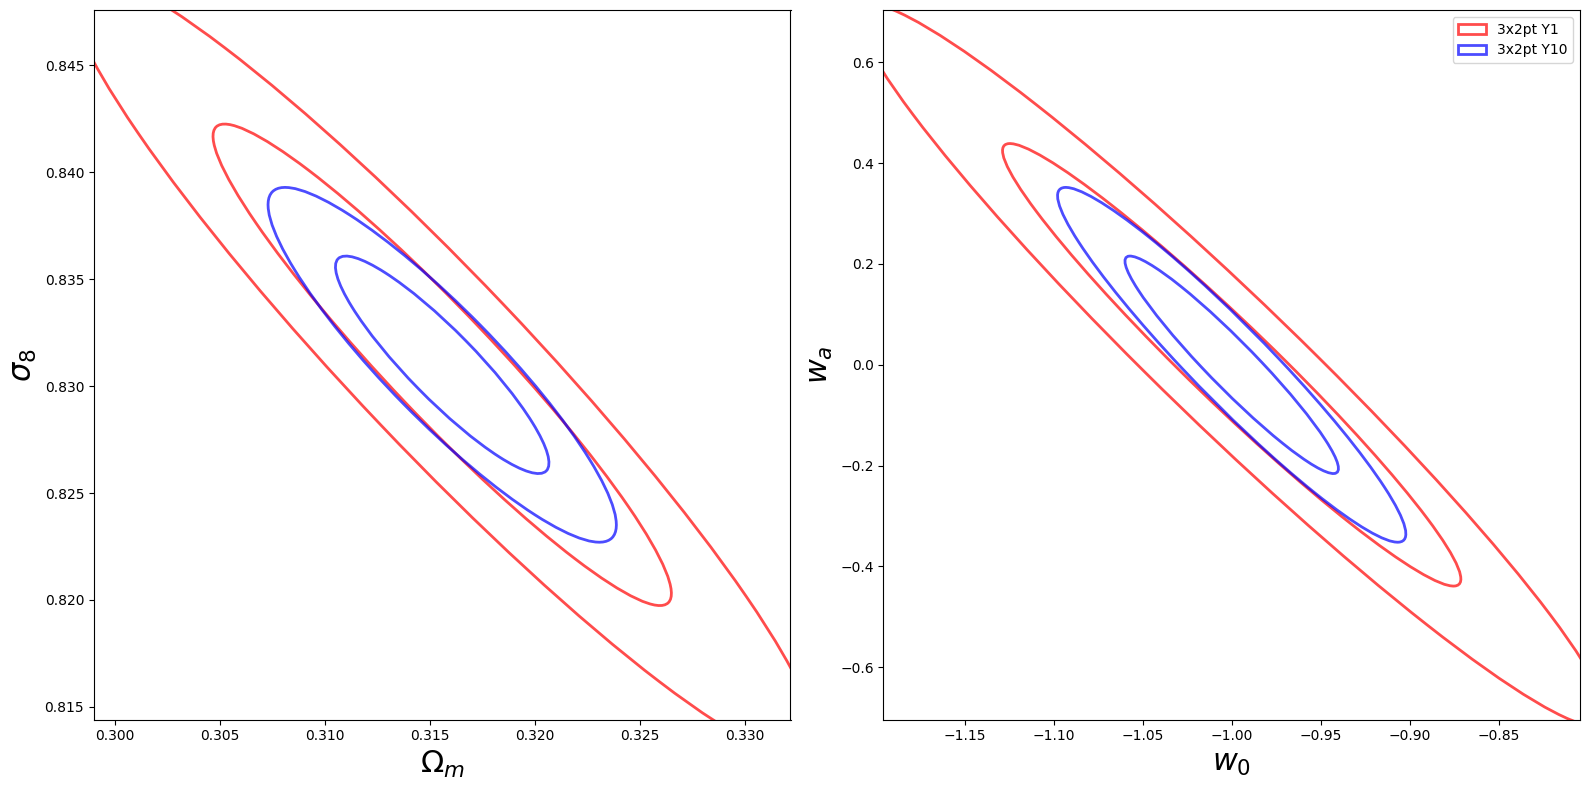

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (16,8))

for paramset in [[['omega_m', 'sigma_8'], ['w_0', 'w_a']]]:
    for j, params in enumerate(paramset):
        # ax[j].set_title('3x2pt', fontsize = 22)
        colors = ['red', 'blue']
        arg = fisher_obj
        labels = ['3x2pt Y1', '3x2pt Y10']
        es = []
        for matrix, label, color in zip([fisher_obj_y1.fisher, fisher_obj.fisher], labels, colors):
            fid=(arg.vals[params[0]], arg.vals[params[1]])
            this_fisher = marginalize(matrix, 
                            arg.param_order.index(params[0]), 
                            arg.param_order.index(params[1]))
            
            for sigmas in [1,2]:
                e, xlim, ylim, _ = plot_contours(
                    this_fisher,
                    sigmas=sigmas, fid=fid
                    )
                if sigmas==1:
                    e.set_label(label)
                    es.append(e)
                e.set_facecolor('none')
                e.set_alpha(0.7)
                e.set_edgecolor(color)
                e.set_linewidth(2.0)
                
                ax[j].add_artist(e)
            #limnew = 1*max(abs(para_bias[params[0]]), abs(para_bias[params[1]]))
            xlim = (arg.vals[params[0]] - 2* xlim, arg.vals[params[0]] + 2* xlim)
            ylim = (arg.vals[params[1]] - 2* ylim, arg.vals[params[1]] + 2* ylim)
            ax[j].set_xlim((xlim))
            ax[j].set_ylim((ylim))
            
            ax[j].set_xlabel(arg.param_labels[arg.param_order.index(params[0])],fontsize = 22)
            ax[j].set_ylabel(arg.param_labels[arg.param_order.index(params[1])],fontsize = 22)
            plt.tight_layout()
    
    ax[j].legend(handles=es)
    
        

In [18]:
def plot_2_contour(Fisher, fisher_matrix1, fisher_matrix2, end = 11, filename = None , labels = ['', '']):

    bias_ell = Fisher.ell
    vals = Fisher.vals
    fisher = [fisher_matrix1, fisher_matrix2]
    cov = [np.linalg.inv(fisher_matrix1),np.linalg.inv(fisher_matrix2) ]
    
    
    colors = ['red', 'blue']
    linestyles = ['--', '-']
    # colors = [colors[0], colors[1]]

    xlim_range = [[0.3,0.4],[-2.5,-0.75]]
    ylim_range = [[0.6,0.85],[-1,4.0]]
    plt.rc('axes', titlesize=14)     # fontsize of the axes title
    plt.rc('axes', labelsize=14)    # fontsize of the x and y labels


    fig = plt.figure(figsize = (15,15))
    fig.subplots_adjust(left=0.1, bottom=0.1, right=1.1, top=1.1, wspace=0.0, hspace=0.0)


    # for count, params in enumerate([['omega_m', 'sigma_8'],
    #                ['w_0', 'w_a']]):

    
    for row in range(end):
        for col in range(row+1,end):
            params = [param_order[row], param_order[col]]

            fid = (vals[params[0]], vals[params[1]])
            es = []

            index1 = param_order.index(params[0])
            index2 = param_order.index(params[1])

            my_xlim = [fid[0] - 3.5*np.sqrt(cov[0][index1][index1]) , fid[0] + 3.5*np.sqrt(cov[0][index1][index1])]
            my_ylim = [fid[1] - 3.5*np.sqrt(cov[0][index2][index2]) , fid[1] + 3.5*np.sqrt(cov[0][index2][index2])]


            for i, matrix in enumerate(fisher):

                e, xlim, ylim, _ = plot_contours(marginalize(matrix, row, col),
                                  sigmas=1,
                                  fid=fid)
                e.set_facecolor('none')
                e.set_edgecolor(colors[i])
                e.set_label(labels[i])
                e.set_alpha(0.9)
                e.set_linewidth(3)
                e.set_linestyle(linestyles[i])
                es.append(e)
                
                e, xlim, ylim, _ = plot_contours(marginalize(matrix, row, col),
                                  sigmas=2,
                                  fid=fid)
                e.set_facecolor('none')
                e.set_edgecolor(colors[i])
                e.set_label(labels[i])
                e.set_alpha(0.9)
                e.set_linewidth(3)
                e.set_linestyle(linestyles[i])

                es.append(e)
                
#                 print(params,marginalize(matrix, row, col) )
            ax = plt.subplot(end,end,end*col+row+1)
            subplot_number = end*col+row+1
# #             print(es)
            
            for i, e in enumerate(es):
                ax.add_artist(e)

            ax.tick_params(
                axis='x',          # changes apply to the x-axis
                direction = 'in',
                which='both',      # both major and minor ticks are affected
                bottom=True,      # ticks along the bottom edge are off
                top=True,         # ticks along the top edge are off
                labelbottom=False)

            ax.tick_params(
                axis='y',          # changes apply to the x-axis
                direction = 'in',
                which='both',      # both major and minor ticks are affected
                left=True,      # ticks along the bottom edge are off
                right=True,         # ticks along the top edge are off
                labelleft=False)

            if subplot_number in list(range(end**2-end,end**2)):
                plt.xlabel(param_labels[param_order.index(params[0])], fontsize = 22)
                ax.tick_params(
                    axis='x',          # changes apply to the x-axis
                    direction = 'in',
                    which='both',      # both major and minor ticks are affected
                    bottom=True,      # ticks along the bottom edge are off
                    top=True,         # ticks along the top edge are off
                    labelbottom=True, rotation = 45)
            if (subplot_number-1)%end==0:
                plt.ylabel(param_labels[param_order.index(params[1])], fontsize = 22)
                #plt.ticklabel_format(axis='y',style='scientific',scilimits=(0,3))
                ax.tick_params(
                    axis='y',          # changes apply to the x-axis
                    direction = 'in',
                    which='both',      # both major and minor ticks are affected
                    left=True,      # ticks along the bottom edge are off
                    right=True,         # ticks along the top edge are off
                    labelleft=True)
            #plt.title(str(subplot_number))
            #plt.xlim([-1.1, -0.9])
            plt.xlim(my_xlim)
            plt.ylim(my_ylim)
            
    plt.subplot(end,end,2*end-2)
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.axis('off')
    for i in range(len(colors)):
        ax.plot([0],[0], linestyles[i], linewidth = 3.0 , color = colors[i], alpha = 0.8,  label = labels[i] )

    ax.legend(fontsize = 18)
    
    if filename != None:
        plt.savefig(filename)


Here we make a 7x7 corner plots for the two Fisher forecasts, beautiful!

In [19]:
cosmo_index = range(7)
param_labels = fisher_obj.param_labels
param_order = list(np.array(fisher_obj.param_order)[cosmo_index])

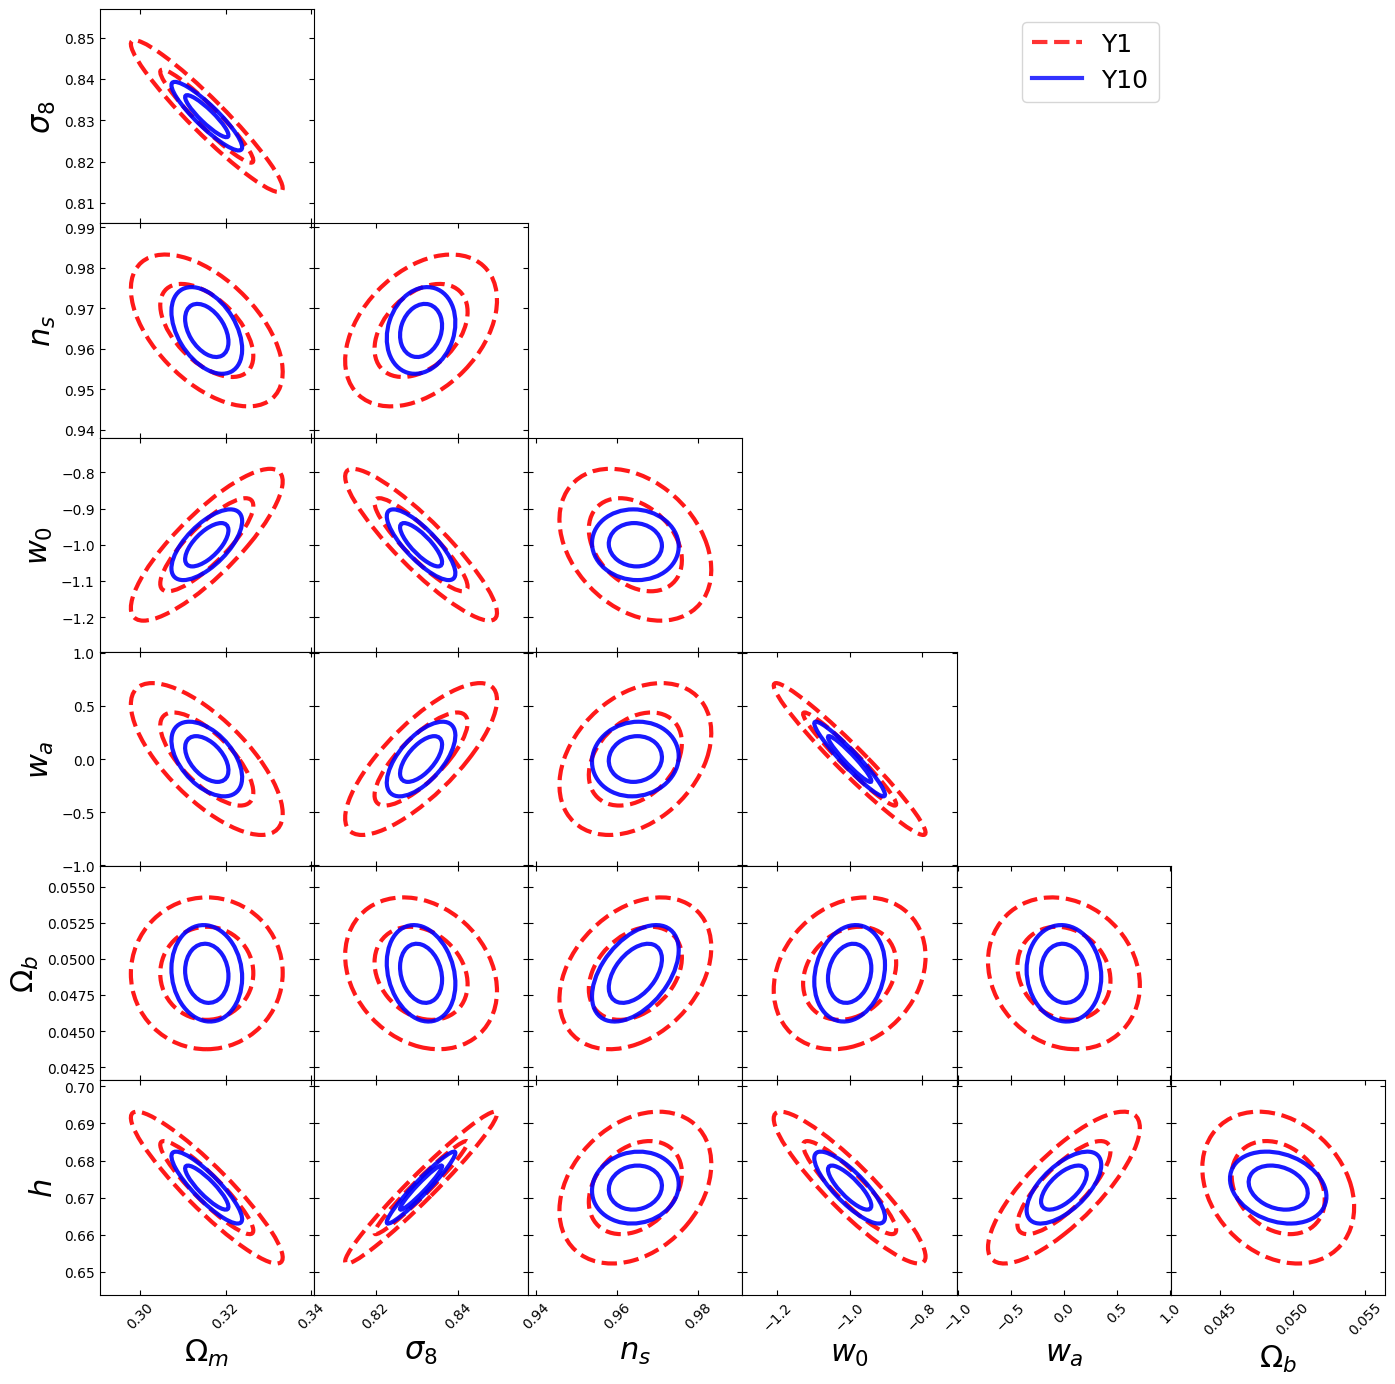

In [20]:
plot_2_contour(fisher_obj, fisher_obj_y1.fisher, fisher_obj.fisher, end = 7, labels = ['Y1', 'Y10'])